In [1]:
%matplotlib inline

import os
from time import time
import datetime
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, log_loss
from scipy.stats import randint as sp_randint
from scipy import interp
from drivendata_validator import DrivenDataValidator

import matplotlib.pyplot as plt

# data directory
DATA_DIR = os.path.join('..', 'data', 'processed')

In [2]:
## Make Submission DataFrame
def make_country_sub(preds, test_feat, country):
    # make sure we code the country correctly
    country_codes = ['A', 'B', 'C']
    
    # get just the poor probabilities
    country_sub = pd.DataFrame(data=preds[:, 1],  # proba p=1
                               columns=['poor'], 
                               index=test_feat.index)

    
    # add the country code for joining later
    country_sub["country"] = country
    return country_sub[["country", "poor"]]

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

##### Household-level survey data: 
This is obfuscated data from surveys conducted by The World Bank, focusing on household-level statistics. The data come from three different countries, and are separated into different files for convenience.

##### Individual-level survey data: 
This is obfuscated data from related surveys conducted by The World Bank, only these focus on individual-level statistics. The set of interviewees and countries involved are the same as the household data, as indicated by shared id indices, but this data includes detailed (obfuscated) information about household members.

##### Submission format:
This gives us the filenames and columns of our submission prediction, filled with all 0.5 as a baseline.

In [3]:
## define data paths
data_paths = {'A': {'train': os.path.join(DATA_DIR, 'A', 'A_hhold_train.csv'), 
                    'test':  os.path.join(DATA_DIR, 'A', 'A_hhold_test.csv')}, 
              
              'B': {'train': os.path.join(DATA_DIR, 'B', 'B_hhold_train.csv'), 
                    'test':  os.path.join(DATA_DIR, 'B', 'B_hhold_test.csv')}, 
              
              'C': {'train': os.path.join(DATA_DIR, 'C', 'C_hhold_train.csv'), 
                    'test':  os.path.join(DATA_DIR, 'C', 'C_hhold_test.csv')}}

In [4]:
# load training data
a_train = pd.read_csv(data_paths['A']['train'], index_col='id')
b_train = pd.read_csv(data_paths['B']['train'], index_col='id')
c_train = pd.read_csv(data_paths['C']['train'], index_col='id')

# load test data
a_test = pd.read_csv(data_paths['A']['test'], index_col='id')
b_test = pd.read_csv(data_paths['B']['test'], index_col='id')
c_test = pd.read_csv(data_paths['C']['test'], index_col='id')

#### The first thing to notice is that each country's surveys have wildly different numbers of columns, so we'll plan on training separate models for each country and combining our predictions for submission at the end.

### Pre-process Data

In [5]:
def pre_process_train_test_data(train, test):
    labels = np.ravel(train.poor)
    train = pd.get_dummies(train.drop('poor', axis=1))
    test =  pd.get_dummies(test)

    # match test set and training set columns
    to_drop = np.setdiff1d(test.columns, train.columns)
    to_add = np.setdiff1d(train.columns, test.columns)

    test.drop(to_drop, axis=1, inplace=True)
    test = test.assign(**{c: 0 for c in to_add})
    
    train.fillna(0, inplace=True)
    test.fillna(0, inplace=True)

    test_indices = test.index
    train_indices = train.index
    train_test = pd.concat([train, test])

    print "Shapes before transformation"
    print "Train : ", train.shape
    print "Test : ", test.shape
    print "Train + Test : ", train_test.shape

    numeric_vals = train_test.select_dtypes(include=['int64', 'float64'])
    scaler = StandardScaler()
    train_test[numeric_vals.columns] = scaler.fit_transform(numeric_vals)

    train = train_test.loc[train_indices, :]
    test  = train_test.loc[test_indices, :]
    
    train['poor'] = labels
    
    print "Shapes after transformation"
    print "Train : ", train.shape
    print "Test : ",  test.shape
    
    return train, test

print 'Preprocessing Training'
print("Country A")
a_train, a_test = pre_process_train_test_data(a_train, a_test)
aX_train = a_train.drop('poor', axis=1)
ay_train = np.ravel(a_train.poor)

print("\nCountry B")
b_train, b_test = pre_process_train_test_data(b_train, b_test)
bX_train = b_train.drop('poor', axis=1)
by_train = np.ravel(b_train.poor)

print("\nCountry C")
c_train, c_test = pre_process_train_test_data(c_train, c_test)
cX_train = c_train.drop('poor', axis=1)
cy_train = np.ravel(c_train.poor)

Preprocessing Training
Country A
Shapes before transformation
Train :  (8203, 859)
Test :  (4041, 859)
Train + Test :  (12244, 859)
Shapes after transformation
Train :  (8203, 860)
Test :  (4041, 859)

Country B
Shapes before transformation
Train :  (3255, 1432)
Test :  (1604, 1432)
Train + Test :  (4859, 1432)
Shapes after transformation
Train :  (3255, 1433)
Test :  (1604, 1432)

Country C
Shapes before transformation
Train :  (6469, 795)
Test :  (3187, 795)
Train + Test :  (9656, 795)
Shapes after transformation
Train :  (6469, 796)
Test :  (3187, 795)


In [6]:
## restructure train data
all_train_data = {'A': {'features': aX_train, 
                        'labels': ay_train},
                  'B': {'features': bX_train,
                        'labels':  by_train}, 
                  'C': {'features': cX_train, 
                        'labels':  cy_train}}

## restructure test data
all_test_data = {'A': {'features': a_test},
                 'B': {'features': b_test},
                 'C': {'features': c_test}}

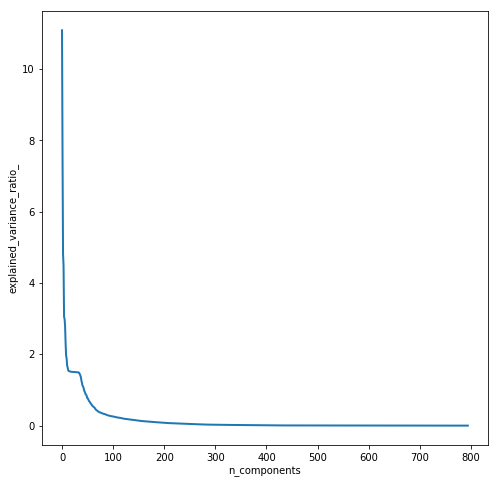

In [25]:
pca = PCA(svd_solver='full')
pca.fit(cX_train)
plt.figure(1, figsize=(8, 8))
plt.clf()
# plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')
plt.show()

In [27]:
pca.score_samples()

TypeError: score_samples() takes exactly 2 arguments (1 given)

### Cross-validation - Tune Parameters

In [8]:
# tune_params = 0
# if tune_params > 0:
#     bestParams = []
#     cv = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
#     for grp in all_train_data:
        
#         print 'Working on group : %s'%(grp)
        
#         # get some data
#         X = all_train_data[grp]['features'].values.astype(np.float32)
#         y = all_train_data[grp]['labels'].astype(np.int16)

#         # build a classifier
#         clf = RandomForestClassifier()
        
#         num_features = np.shape(X)[1]
#         print 'Number of features : ', num_features
        
#         # specify parameters and distributions to sample from
#         param_dist = {"n_estimators": sp_randint(25, 1000),
#                       "max_depth": sp_randint(25, num_features/2),
#                       "max_features": sp_randint(25, num_features-5),
#                       "min_samples_split": sp_randint(1, num_features/2),
#                       "min_samples_leaf": sp_randint(1, num_features/4),
#                       "bootstrap": [True, False],
#                       "criterion": ["gini", "entropy"]}

#         # run randomized search
#         n_iter_search = 500
#         random_search = RandomizedSearchCV(clf, scoring='neg_log_loss', 
#                                            param_distributions=param_dist, 
#                                            n_iter=n_iter_search, cv=cv,
#                                            return_train_score=False, 
#                                            n_jobs=8)

#         start = time()
#         random_search.fit(X, y)
#         gridSearchScores = pd.DataFrame(random_search.cv_results_)
#         gridSearchScores.sort_values(['mean_test_score'], axis=0, ascending=False, inplace=True)
#         gridSearchScores.head()

#         all_train_data[grp]['best_parameters'] = gridSearchScores.iloc[0,:]
#         bestParams.append(all_train_data[grp]['best_parameters'])
    
#     now = datetime.datetime.now()
#     timestamp = now.strftime("%Y%m%d_%H%M")
#     bestParamsDF = pd.DataFrame(bestParams, index=['A', 'B', 'C'])
#     bestParamsDF.to_csv('bestParametersAllThreeModels_%s.txt'%(timestamp), sep='\t', index_label='group')
#     print "Best Parameters.....\n", bestParamsDF.iloc[:, 3:9]
# else:
#     print 'Using the previously optimized parameters......'
#     bestParamsDF = pd.read_csv('bestParametersAllThreeModels_round2.txt', sep='\t', index_col='group')

### Training Phase

In [9]:
# ## Train Model
# print "\nTraining Models........."
# trained_models = {}
# for grp in all_train_data:
#     trained_models[grp] = RandomForestClassifier(bootstrap=bestParamsDF.loc[grp, 'param_bootstrap'],
#                                      min_samples_leaf=bestParamsDF.loc[grp, 'param_min_samples_leaf'],
#                                      n_estimators=bestParamsDF.loc[grp, 'param_n_estimators'], 
#                                      min_samples_split=bestParamsDF.loc[grp, 'param_min_samples_split'],
#                                      criterion=bestParamsDF.loc[grp, 'param_criterion'],
#                                      max_features=bestParamsDF.loc[grp, 'param_max_features'],
#                                      max_depth=bestParamsDF.loc[grp, 'param_max_depth'], n_jobs=8)
#     trained_models[grp].fit(all_train_data[grp]['features'], all_train_data[grp]['labels'])

### Testing Phase

In [10]:
# ## Predict
# print "\nTesting Models........."
# predictions = {}
# for grp in all_train_data:
#     predictions[grp] = trained_models[grp].predict_proba(all_test_data[grp]['features'])

### Validate and Submit

In [11]:
# # convert preds to data frames
# predictionsDF = {}
# for grp in all_train_data:
#     predictionsDF[grp] = make_country_sub(predictions[grp], all_test_data[grp]['features'], grp)

# submission = []
# submission = pd.concat([predictionsDF['A'], predictionsDF['B'], predictionsDF['C']])

# ## Submission Format
# now = datetime.datetime.now()
# timestamp = now.strftime("%Y%m%d_%H%M")
# submission.to_csv('../data/%s_submission.csv'%(timestamp))

# # no parameters unless we have a read_csv kwargs file
# v = DrivenDataValidator()

# if v.is_valid('../data/submission_format.csv', '../data/%s_submission.csv'%(timestamp)):
#     print "I am awesome."
# else:
#     print "I am not so cool."